## SELECT BEST

SelectKBest è un metodo di selezione delle feature che sceglie le migliori caratteristiche basandosi su test statistici univariati. Ecco come funziona nel dettaglio:

**Funzionamento base:**
Valuta ogni feature individualmente rispetto alla variabile target
Assegna un punteggio a ciascuna feature
Seleziona le k feature con i punteggi più alti

**Parametri principali:**
- k: numero di feature da selezionare


score_func: la funzione di scoring da utilizzare. Le più comuni sono:
- f_classif: per problemi di classificazione (usa ANOVA F-value)
- chi2: per dati non negativi
- mutual_info_classif: per relazioni non lineari
- f_regression: per problemi di regressione

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X, y = make_classification(
                            n_samples=1000,
                            n_features=20,
                            n_informative=10,
                            n_redundant=5,
                            random_state=42
                        )

feature_names = [f'feature_{i}' for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=667,
                                                    )

In [2]:
selector = SelectKBest(score_func=f_classif, k=10)  # Selezioniamo le 10 feature migliori

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

scores = pd.DataFrame({
                        'Feature': feature_names,
                        'Score': selector.scores_,
                        'P-value': selector.pvalues_,
                        'Selected': selector.get_support()
                    })
scores = scores.sort_values('Score', ascending=False)

In [3]:
selected_features = X.columns[selector.get_support()].tolist()

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [4]:
model.feature_importances_

array([0.09002307, 0.06236151, 0.0382053 , 0.10611224, 0.06207538,
       0.14327424, 0.19224836, 0.09505503, 0.07877484, 0.13187004])

In [5]:
y_pred = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

# Stampiamo i risultati
print("Feature selezionate:", selected_features)
print("\nPunteggi delle feature:")
print(scores)
print(f"\nAccuratezza del modello: {accuracy:.3f}")

Feature selezionate: ['feature_2', 'feature_4', 'feature_5', 'feature_7', 'feature_9', 'feature_11', 'feature_14', 'feature_15', 'feature_16', 'feature_17']

Punteggi delle feature:
       Feature       Score       P-value  Selected
14  feature_14  206.771435  7.350713e-42      True
15  feature_15  117.163737  1.427791e-25      True
11  feature_11   74.570317  3.155531e-17      True
16  feature_16   63.434265  5.704141e-15      True
17  feature_17   59.602693  3.473847e-14      True
9    feature_9   56.520045  1.496866e-13      True
2    feature_2   47.470869  1.133027e-11      True
7    feature_7   40.086458  4.051863e-10      True
4    feature_4   16.797937  4.583126e-05      True
5    feature_5    6.670594  9.978616e-03      True
13  feature_13    2.203228  1.381169e-01     False
12  feature_12    1.787253  1.816422e-01     False
3    feature_3    0.503172  4.783169e-01     False
19  feature_19    0.171646  6.787648e-01     False
8    feature_8    0.116473  7.329820e-01     False
10

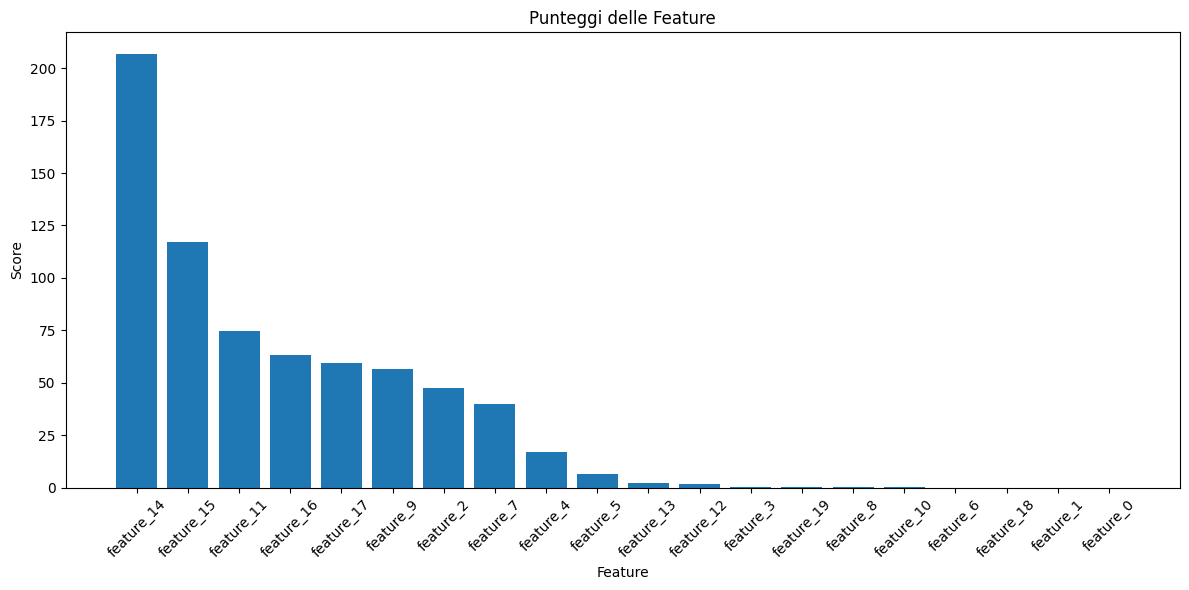

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(scores['Feature'], scores['Score'])
plt.xticks(rotation=45)
plt.title('Punteggi delle Feature')
plt.xlabel('Feature')
plt.ylabel('Score')
plt.tight_layout()

## RFE Selection
RFE (Recursive Feature Elimination) è un metodo di selezione delle feature più sofisticato che funziona in modo iterativo. Ecco il suo funzionamento dettagliato:

1) Processo Iterativo:

- Parte con tutte le feature
- Addestra un modello (es. RandomForest, SVM, etc.)
- Valuta l'importanza di ogni feature
- Elimina la feature (o le feature) meno importante
- Ripete il processo finché non raggiunge il numero desiderato di feature


2) Esempio dettagliato del processo:

- Supponiamo di avere 10 feature e vogliamo selezionarne 5
- Iterazione 1: addestra modello → elimina feature meno importante → rimangono 9
- Iterazione 2: riaddestra → elimina altra feature → rimangono 8
 E così via fino a quando rimangono solo le 5 feature desiderate

In [7]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X, y = make_classification(
                            n_samples=1000,
                            n_features=20,
                            n_informative=10,
                            n_redundant=5,
                            random_state=42
                        )

feature_names = [f'feature_{i}' for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=667,
                                                    )

In [9]:
base_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Creiamo l'oggetto RFE - Vogliamo selezionare le 10 feature più importanti
rfe = RFE(estimator=base_model, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)

In [10]:
selected_features = X_train.columns[rfe.support_].tolist()

feature_ranking = pd.DataFrame({
                                'Feature': feature_names,
                                'Selected': rfe.support_,
                                'Ranking': rfe.ranking_
                                })
feature_ranking = feature_ranking.sort_values('Ranking')

In [11]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

final_model = RandomForestClassifier(n_estimators=100,
                                    random_state=42,
                                    )
final_model.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [12]:
y_pred = final_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)

print(f"\nFeature selezionate:\n{selected_features}")
print(f"\nRanking completo delle feature:\n{feature_ranking}")
print(f"\nAccuratezza del modello con le feature selezionate: {accuracy:.3f}")


Feature selezionate:
['feature_1', 'feature_2', 'feature_3', 'feature_7', 'feature_9', 'feature_11', 'feature_14', 'feature_15', 'feature_17', 'feature_18']

Ranking completo delle feature:
       Feature  Selected  Ranking
9    feature_9      True        1
1    feature_1      True        1
2    feature_2      True        1
3    feature_3      True        1
17  feature_17      True        1
7    feature_7      True        1
18  feature_18      True        1
15  feature_15      True        1
11  feature_11      True        1
14  feature_14      True        1
16  feature_16     False        2
12  feature_12     False        3
4    feature_4     False        4
8    feature_8     False        5
0    feature_0     False        6
5    feature_5     False        7
6    feature_6     False        8
10  feature_10     False        9
19  feature_19     False       10
13  feature_13     False       11

Accuratezza del modello con le feature selezionate: 0.880
